In [1]:
import numpy as np
import pandas as pd
import bioframe
import cooler
import cooltools
from cooltools.lib.numutils import adaptive_coarsegrain
from cooltools.lib.plotting import *

import multiprocess as mp
num_cores = mp.cpu_count()

import matplotlib.pyplot as plt
import logging, matplotlib
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

## parameters for nice plots
plt.rcParams['image.interpolation'] = 'none'
plt.rcParams['image.cmap'] = 'fall'
plt.rcParams['axes.grid'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['font.size'] = 10

from akita_utils.tsv_utils import (
    filter_by_chrmlen,
    filter_by_overlap_num,
    filter_by_chromID,
)

/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:652: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_correction_symmetric(
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:727: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def iterative_co

### Reading dots and boundaries tables

In [2]:
# dot data
dots_file = "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features/mustache_HiC_ES.mm10.mapq_30.10000.tsv"
chrom_sizes_file = "/project/fudenber_735/genomes/mm10/mm10.chrom.sizes.reduced"
seq_length = 1310720
chromID_to_drop = ["chrX", "chrY", "chrM"]

dots = pd.read_csv(dots_file, sep="\t")
dots = filter_by_chromID(dots, chrom_column='BIN1_CHR', chrID_to_drop=chromID_to_drop)
dots = filter_by_chromID(dots, chrom_column='BIN2_CHROMOSOME', chrID_to_drop=chromID_to_drop)
dots = dots.rename(columns={"BIN1_CHR": "chrom", "BIN1_START": "start", "BIN1_END": "end"})

dots = filter_by_chrmlen(
        dots,
        chrom_sizes_file,
        seq_length,
    )

dots = dots.rename(columns={"chrom": "chrom1", "start": "start1", "end": "end1"})
dots = dots.rename(columns={"BIN2_CHROMOSOME": "chrom", "BIN2_START": "start", "BIN2_END": "end"})

dots = filter_by_chrmlen(
        dots,
        chrom_sizes_file,
        seq_length,
    )
dots = dots.rename(columns={"chrom": "chrom2", "start": "start2", "end": "end2"})


# boundary data
boundaries_file = "/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/features/bonev2017.HiC_ES.mm10.mapq_30.1000.window_200000.insulation"

boundaries = pd.read_csv(boundaries_file, sep="\t")

# filtering strong boundaries

window_size = boundaries_file.split("window_")[1].split(".")[0]
boundary_key, insulation_key = (
    f"boundary_strength_{window_size}",
    f"log2_insulation_score_{window_size}",
)

boundary_strength_thresh = 0.25
boundary_insulation_thresh = 0

boundaries = boundaries.iloc[
    (boundaries[boundary_key].values > boundary_strength_thresh)
    * (
        boundaries[insulation_key].values
        < boundary_insulation_thresh
    )
]

In [3]:
# let's select 16 random dots
df_of_interest = dots.sample(n=16)

In [4]:
# analysis parameters

res = 10_000 ## common resolution for analyzing TADs/dots

genome_folder = '/project/fudenber_735/genomes/mm10/'
genome_fasta = genome_folder+'mm10.fa'
genome_chromsizes = genome_folder+'mm10.chrom.sizes.reduced'
                         
# high-resolution reprocessed publically-available data from Bonev et al. 2017
bonev_file = '/project/fudenber_735/GEO/bonev_2017_GSE96107/distiller-0.3.1_mm10/results/coolers/HiC_ES.mm10.mapq_30.1000.mcool'
bonev_cooler = cooler.Cooler(bonev_file+'::resolutions/'+str(res))

/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numutils.py:1376: RuntimeWarning: invalid value encountered in divide
  val_cur = ar_cur / armask_cur
/tmp/SLURM_23003404/ipykernel_92090/3203012906.py:29: RuntimeWarning: divide by zero encountered in log10
  np.log10(mat),
/home1/smaruj/miniconda3/envs/basenji_py3.9_tf2.15/lib/python3.9/site-packages/cooltools/lib/numu

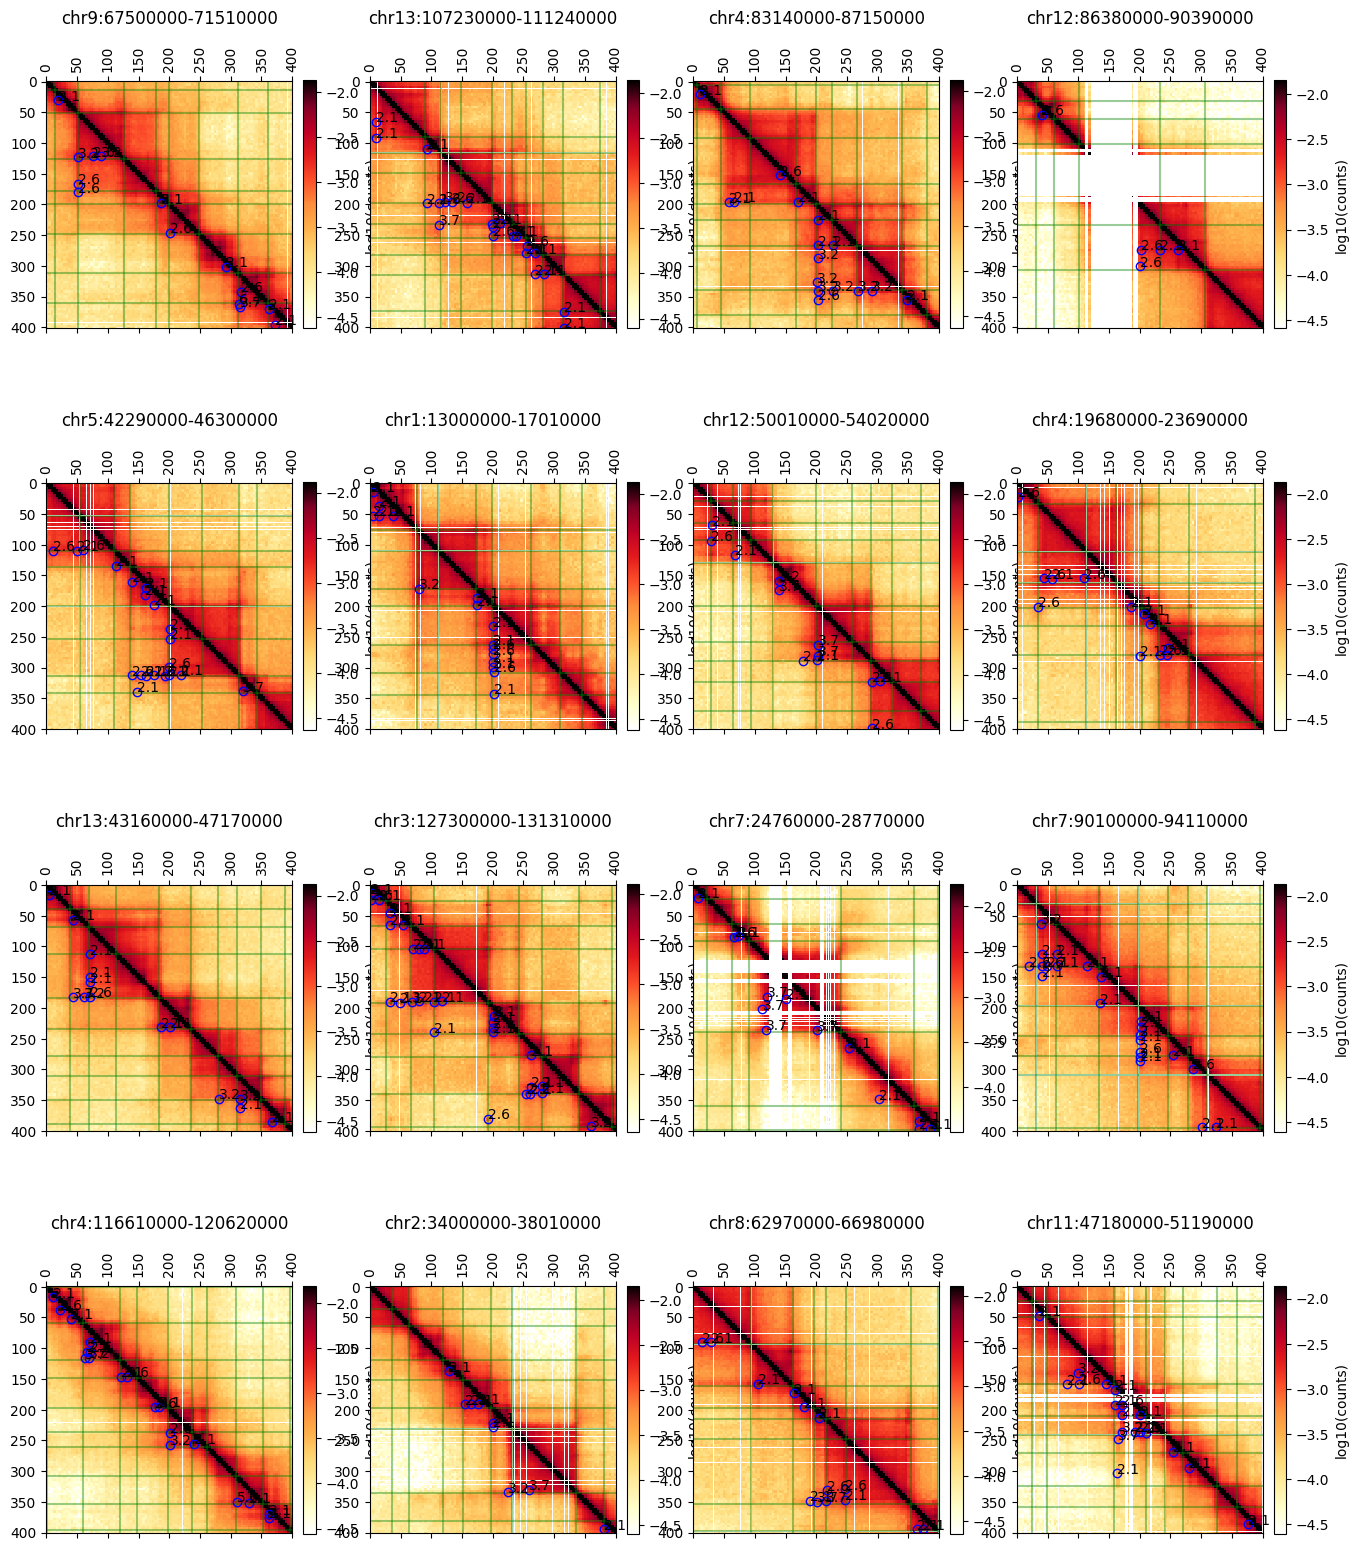

In [5]:
plt_width = 4
num_plots = 4
c=0
fig = plt.figure(figsize=(num_plots*plt_width, num_plots*(plt_width+1)))

padding = 2000000
smoothed = '_smoothed'
fetch_region = True

for s in df_of_interest.itertuples():
    chrom = s.chrom1
    start = s.start1 
    end = s.end1
    mseq_str = '%s:%d-%d' % (chrom, start-padding, end+padding)
    region_start = start-padding
    region_boundaries = bioframe.select(boundaries, mseq_str, cols=['chrom','start','end'])
    
    if fetch_region:
        mat = bonev_cooler.matrix(balance=True).fetch(mseq_str)
    
    if smoothed == '_smoothed': 
        mat = adaptive_coarsegrain(mat,  mat,  cutoff=2, max_levels=2)

    c+=1
    plt.subplot(num_plots,num_plots,c)
    vm = np.log10(np.nanmedian(np.diag(mat,3))*.5)

    im = plt.matshow(
        np.log10(mat),
        vmin=vm-2.5, vmax=vm+.25, fignum=False) 
    
    for boundary_index in range(len(region_boundaries)):
        boundary_start_bin, boundary_end_bin = ((region_boundaries[['start','end']].iloc[boundary_index].values.astype(int) - (start-padding)) //res )
        for boundary_bin in range(boundary_start_bin, boundary_end_bin):
            plt.axvline(x=boundary_bin, color='green', alpha=0.4)
            plt.axhline(y=boundary_bin, color='green', alpha=0.4)

    region_dots = bioframe.select(dots, mseq_str, cols=['chrom1','start1','end1'])
    for i in range(len(region_dots)):
        s1,s2,e1,e2 =( ( region_dots[['start1','end1','start2','end2']].iloc[i].values.astype(int)
                        -region_start) //res ) 
        s,e = .5*(s1+s2), .5*(e1+e2)
        if s < 0 or e > len(mat): continue
        plt.plot(  s,e,'o',lw=3.25,color="blue",mfc='none')
        plt.text(  s,e, np.round(float(region_dots.iloc[i].DETECTION_SCALE),1))
    
    plt.colorbar(im ,fraction=0.046, pad=0.04, label='log10(counts)')
    plt.title(mseq_str , y=1.2)
    plt.grid(False)
    plt.xticks(rotation=90)